0. 구글 드라이브 연동 & 기본 설정

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 시드 고정 (재현성)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 이미지/배치 설정
IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
TARGET_PER_CLASS = 500   # train에서 클래스별 목표 개수

# ★ 주어진 경로
BASE_DIR  = '/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

# train 내 폴더들
normal_train_dir = os.path.join(TRAIN_DIR, 'normal')
type1_train_dir  = os.path.join(TRAIN_DIR, 'type1')
type2_train_dir  = os.path.join(TRAIN_DIR, 'type2')

# SMOTE 결과 저장할 폴더
type1_smote_dir = os.path.join(TRAIN_DIR, 'type1(SMOTE)')
type2_smote_dir = os.path.join(TRAIN_DIR, 'type2(SMOTE)')

print("TRAIN_DIR :", TRAIN_DIR)
print("TEST_DIR  :", TEST_DIR)
print("normal_train_dir :", normal_train_dir)
print("type1_train_dir  :", type1_train_dir)
print("type2_train_dir  :", type2_train_dir)
print("type1_smote_dir  :", type1_smote_dir)
print("type2_smote_dir  :", type2_smote_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TRAIN_DIR : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train
TEST_DIR  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/test
normal_train_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/normal
type1_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type1
type2_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type2
type1_smote_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type1(SMOTE)
type2_smote_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type2(SMOTE)


1. 라이브러리 & 기존 데이터셋 정보 확인

In [8]:
def get_image_paths(folder):

    if not os.path.exists(folder):
        return []
    paths = []
    for name in os.listdir(folder):
        p = os.path.join(folder, name)
        if not os.path.isfile(p):
            continue
        try:
            with Image.open(p) as im:
                im.verify()
            paths.append(p)
        except Exception:
            # 이미지가 아니면 무시
            pass
    return sorted(paths)

normal_paths_orig = get_image_paths(normal_train_dir)
type1_paths_orig  = get_image_paths(type1_train_dir)
type2_paths_orig  = get_image_paths(type2_train_dir)

print("=== 기존 train 데이터셋(증강 전) ===")
print("normal 개수:", len(normal_paths_orig))
print("type1  개수:", len(type1_paths_orig))
print("type2  개수:", len(type2_paths_orig))

=== 기존 train 데이터셋(증강 전) ===
normal 개수: 500
type1  개수: 25
type2  개수: 25


2. SMOTE로 type1, tyoe2 각각 475장 생성

In [9]:
# 2-1. SMOTE 함수 정의
def load_images(paths, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    """경로 리스트에서 이미지를 로드해서 [0,1] float32 배열로 반환."""
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        imgs.append(img)
    return np.stack(imgs, axis=0)  # (N, H, W, C)

def smote_augment(X, n_new, k=5):
    """
    X: (N, d) 소수 클래스 벡터들
    n_new: 생성할 샘플 수
    k: 최근접 이웃 개수
    """
    n_samples = X.shape[0]
    if n_samples < 2 or n_new <= 0:
        return np.empty((0, X.shape[1]), dtype=X.dtype)

    k = min(k, n_samples - 1)

    nbrs = NearestNeighbors(n_neighbors=k+1)
    nbrs.fit(X)
    neighbors = nbrs.kneighbors(X, return_distance=False)

    synthetic = []
    for _ in range(n_new):
        i = random.randint(0, n_samples - 1)
        # 자기 자신 제외한 이웃 중 하나 선택
        nn_index = random.choice(neighbors[i, 1:])
        lam = random.random()
        new_sample = X[i] + lam * (X[nn_index] - X[i])
        synthetic.append(new_sample)
    return np.stack(synthetic, axis=0)

def save_synthetic_images(synthetic_imgs, target_dir, prefix):
    """
    synthetic_imgs: float32, [0,1], shape = (N, H, W, 3)
    target_dir    : 저장할 폴더 (예: type1_smote_dir)
    prefix        : 파일 이름 접두사 (예: 'smote_type1')
    """
    os.makedirs(target_dir, exist_ok=True)
    # 이미 prefix로 시작하는 파일이 있다면, 그 뒤 번호부터 이어서 저장
    existing = get_image_paths(target_dir)
    existing_prefix_count = sum(
        1 for p in existing if os.path.basename(p).startswith(prefix)
    )
    start_idx = existing_prefix_count

    for i, img in enumerate(synthetic_imgs):
        img_uint8 = (img * 255).astype(np.uint8)
        im = Image.fromarray(img_uint8)
        filename = f"{prefix}_{start_idx + i:05d}.png"
        im.save(os.path.join(target_dir, filename))

def augment_class_with_smote(orig_dir, smote_dir, prefix, target_total=TARGET_PER_CLASS):
    """
    orig_dir : 원본 이미지 폴더 (type1, type2)
    smote_dir: SMOTE로 생성한 이미지 저장 폴더 (type1(SMOTE), type2(SMOTE))
    prefix   : 생성 이미지 파일 이름 접두사
    target_total: 최종적으로 orig + smote 합쳐서 사용하고 싶은 이미지 수

    - orig_dir + smote_dir 안의 이미지 개수를 보고
      이미 target_total 이상이면 아무 것도 안 함 (여러 번 실행해도 안전).
    - SMOTE 기반으로 사용할 이미지는 orig_dir 안의 이미지들만 사용.
    """
    orig_paths  = get_image_paths(orig_dir)
    smote_paths = get_image_paths(smote_dir)

    total_now = len(orig_paths) + len(smote_paths)
    print(f"\n[{orig_dir}] 현재 orig: {len(orig_paths)}, SMOTE: {len(smote_paths)}, 합계: {total_now}")

    if total_now >= target_total:
        print("이미 target_total 이상이므로 SMOTE 생성 생략")
        return

    if len(orig_paths) < 2:
        raise ValueError("SMOTE를 위해서는 최소 2장 이상의 원본 이미지가 필요합니다.")

    to_create = target_total - total_now
    print("생성할 SMOTE 개수:", to_create)

    imgs = load_images(orig_paths)              # (N, H, W, C)
    X = imgs.reshape(imgs.shape[0], -1)        # (N, d)

    synthetic_flat = smote_augment(X, n_new=to_create, k=5)
    synthetic = synthetic_flat.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    synthetic = np.clip(synthetic, 0.0, 1.0)

    save_synthetic_images(synthetic, smote_dir, prefix)

    # 최종 개수 확인
    smote_paths_after = get_image_paths(smote_dir)
    total_after = len(orig_paths) + len(smote_paths_after)
    print("SMOTE 저장 후 SMOTE 개수:", len(smote_paths_after))
    print("증강 이후 총 개수 (orig + SMOTE):", total_after)

In [10]:
# 2-2. SMOTE 적용
augment_class_with_smote(
    orig_dir=type1_train_dir,
    smote_dir=type1_smote_dir,
    prefix="smote_type1",
    target_total=TARGET_PER_CLASS
)

augment_class_with_smote(
    orig_dir=type2_train_dir,
    smote_dir=type2_smote_dir,
    prefix="smote_type2",
    target_total=TARGET_PER_CLASS
)


[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type1] 현재 orig: 25, SMOTE: 0, 합계: 25
생성할 SMOTE 개수: 475
SMOTE 저장 후 SMOTE 개수: 475
증강 이후 총 개수 (orig + SMOTE): 500

[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_SMOTE/train/type2] 현재 orig: 25, SMOTE: 0, 합계: 25
생성할 SMOTE 개수: 475
SMOTE 저장 후 SMOTE 개수: 475
증강 이후 총 개수 (orig + SMOTE): 500


3. 생성된 이미지 개수 확인

In [11]:
type1_orig_paths  = get_image_paths(type1_train_dir)
type1_smote_paths = get_image_paths(type1_smote_dir)
type2_orig_paths  = get_image_paths(type2_train_dir)
type2_smote_paths = get_image_paths(type2_smote_dir)

print("\n=== 증강 이후 train 데이터 구조 확인 ===")
print("type1 원본 개수:", len(type1_orig_paths))
print("type1 SMOTE 개수:", len(type1_smote_paths))
print("type1 합계:", len(type1_orig_paths) + len(type1_smote_paths))

print("\ntype2 원본 개수:", len(type2_orig_paths))
print("type2 SMOTE 개수:", len(type2_smote_paths))
print("type2 합계:", len(type2_orig_paths) + len(type2_smote_paths))


=== 증강 이후 train 데이터 구조 확인 ===
type1 원본 개수: 25
type1 SMOTE 개수: 475
type1 합계: 500

type2 원본 개수: 25
type2 SMOTE 개수: 475
type2 합계: 500


4. 새로 생성된 이미지 예시 확인 (랜덤 10장)

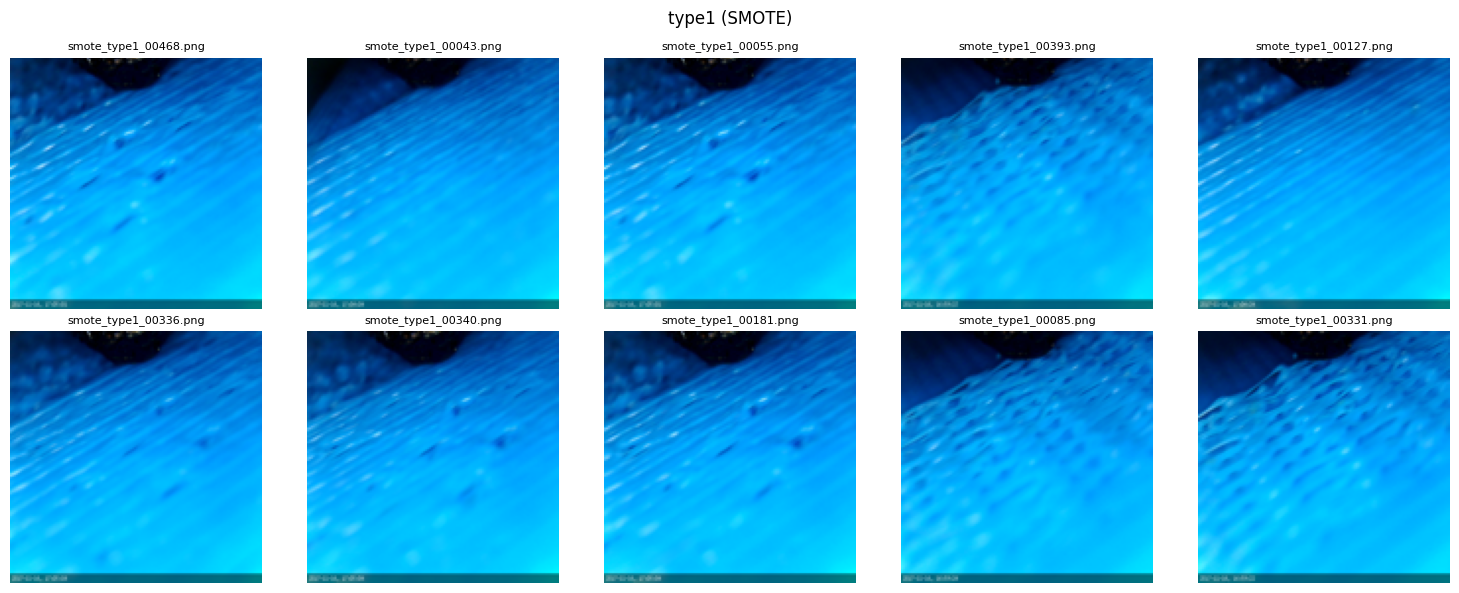

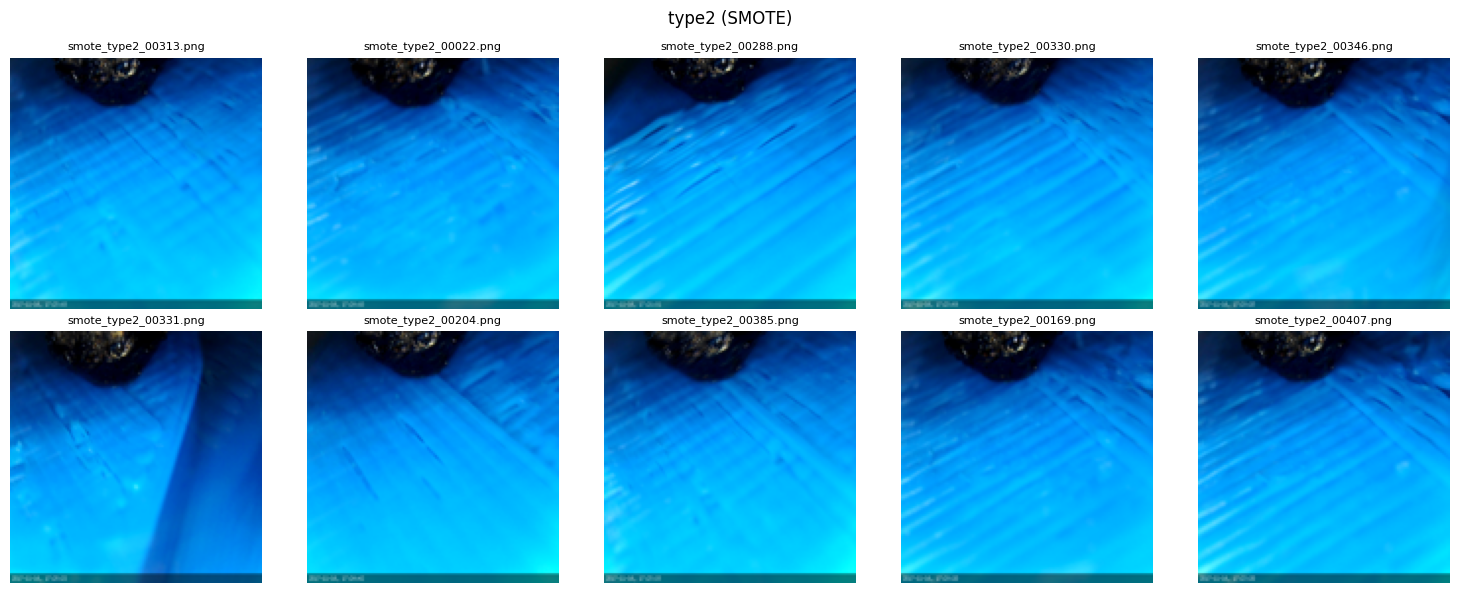

In [12]:
def show_random_images(paths, n=10, title=""):
    sample_paths = random.sample(paths, min(n, len(paths)))
    n_cols = 5
    n_rows = int(np.ceil(len(sample_paths) / n_cols))

    plt.figure(figsize=(n_cols*3, n_rows*3))
    for idx, p in enumerate(sample_paths):
        img = Image.open(p).convert("RGB")
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(p), fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(type1_smote_paths, n=10, title="type1 (SMOTE)")
show_random_images(type2_smote_paths, n=10, title="type2 (SMOTE)")

5. 새로운 데이터셋 (총 1500장) CNN 학습

In [13]:
# 5-1. 학습에 쓸 경로 / 라벨 구성
CLASS_NAMES = ['normal', 'type1', 'type2']
label_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
print("label_to_index:", label_to_index)

def sample_paths_for_class(base_paths, smote_paths=None, max_count=TARGET_PER_CLASS):
    """
    base_paths: 원본 이미지 경로 리스트
    smote_paths: SMOTE 이미지 경로 리스트 (없으면 None)
    max_count: 이 클래스에서 최종 사용할 이미지 수
    """
    all_paths = list(base_paths)
    if smote_paths is not None:
        all_paths.extend(smote_paths)

    if len(all_paths) < max_count:
        print(f"[경고] 이 클래스에 이미지가 {len(all_paths)}장뿐이라 {max_count}장까지 못 채웁니다.")
        # 있는 만큼만 사용
        return all_paths
    elif len(all_paths) > max_count:
        return random.sample(all_paths, max_count)
    else:
        return all_paths

# normal은 SMOTE 안 했다고 가정
normal_paths_for_train = sample_paths_for_class(
    base_paths=normal_paths_orig,
    smote_paths=None,
    max_count=TARGET_PER_CLASS
)

type1_paths_for_train = sample_paths_for_class(
    base_paths=type1_orig_paths,
    smote_paths=type1_smote_paths,
    max_count=TARGET_PER_CLASS
)

type2_paths_for_train = sample_paths_for_class(
    base_paths=type2_orig_paths,
    smote_paths=type2_smote_paths,
    max_count=TARGET_PER_CLASS
)

print("\n=== 학습에 실제로 사용할 개수 ===")
print("normal:", len(normal_paths_for_train))
print("type1 :", len(type1_paths_for_train))
print("type2 :", len(type2_paths_for_train))

# 전체 train 리스트 + 라벨 만들기
train_paths = (
    normal_paths_for_train +
    type1_paths_for_train +
    type2_paths_for_train
)
train_labels = (
    [label_to_index['normal']] * len(normal_paths_for_train) +
    [label_to_index['type1']]  * len(type1_paths_for_train) +
    [label_to_index['type2']]  * len(type2_paths_for_train)
)

# 섞기
combined = list(zip(train_paths, train_labels))
random.shuffle(combined)
train_paths, train_labels = zip(*combined)
train_paths  = list(train_paths)
train_labels = list(train_labels)

print("\n총 train 샘플 수:", len(train_paths))

label_to_index: {'normal': 0, 'type1': 1, 'type2': 2}

=== 학습에 실제로 사용할 개수 ===
normal: 500
type1 : 500
type2 : 500

총 train 샘플 수: 1500


In [15]:
# 5-2. tf.data 파이프라인 생성
AUTOTUNE = tf.data.AUTOTUNE

def process_path(path, label):
    # 파일 읽기
    img_bytes = tf.io.read_file(path)

    # 이미지 디코딩 (jpg/png 등 자동 인식)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    # rank/shape 명시적으로 지정 (H, W, C)
    img.set_shape([None, None, 3])

    # 크기 변경
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # [0,255] → [0,1] float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, label

# 기본 dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 증강
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

def augment(image, label):
    return data_augmentation(image, training=True), label

train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=SEED)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [16]:
# 5-3. CNN 모델 정의 & 학습
num_classes = len(CLASS_NAMES)

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4873 - loss: 61.5166
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7715 - loss: 0.4918
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8612 - loss: 0.3356
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8748 - loss: 0.2911
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9069 - loss: 0.2768
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8971 - loss: 0.2524
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8983 - loss: 0.3348
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8989 - loss: 0.3004
Epoch 9/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8982 - loss: 0.2830
Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9211 - loss: 0.2390
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9570 - loss: 0.1387
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9537 -

6. test 데이터로 성능 확인

In [17]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,          # normal, type1, type2 순서를 train과 맞춤
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# [0,255] → [0,1]
test_ds = test_ds.map(
    lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y),
    num_parallel_calls=AUTOTUNE
)
test_ds = test_ds.prefetch(AUTOTUNE)

# y_true, y_pred 계산
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

Found 300 files belonging to 3 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step
y_true shape: (300,)
y_pred shape: (300,)


7. macro F-score, precision, recall

In [18]:
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall   : {recall_macro:.4f}")
print(f"Macro F1-score : {f1_macro:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Macro Precision: 0.8784
Macro Recall   : 0.8200
Macro F1-score : 0.8142

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.65      1.00      0.79       100
       type1       0.98      0.53      0.69       100
       type2       1.00      0.93      0.96       100

    accuracy                           0.82       300
   macro avg       0.88      0.82      0.81       300
weighted avg       0.88      0.82      0.81       300



8. Confusion Matrix

Confusion Matrix:
 [[100   0   0]
 [ 47  53   0]
 [  6   1  93]]


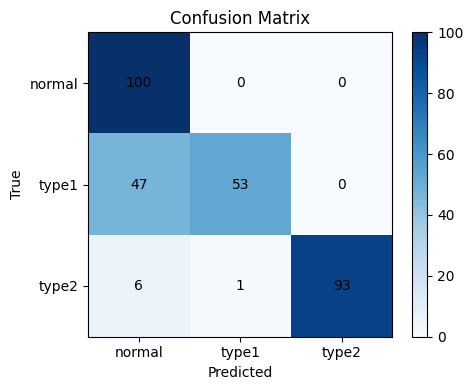

In [19]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks(np.arange(len(CLASS_NAMES)))
ax.set_yticks(np.arange(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticklabels(CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black")

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.tight_layout()
plt.show()